In [1]:
'Empty seat or carrier seat Classification using XG Boost model and MLP model'

'Empty seat or carrier seat Classification using XG Boost model and MLP model'

In [3]:
import gc
gc.collect()

0

In [5]:
%reset -f

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

# Emptyseat measurements

In [10]:
import numpy as np
import pandas as pd
# Replace 'your_array_file.npy' with the actual file path of your saved NumPy array
file_path = 'Emptyseat_npy_array_Lowpassfiltered_label.npy'

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Now 'loaded_array' contains the NumPy array data that was saved in the file
dataframe_emptyseat = pd.DataFrame(loaded_array,columns=['Frequency','FFT Magnitude','Phase','Object_Presence'])
dataframe_emptyseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,88895.479976,0.000000,0.0
1,92.390019,42749.875976,3.114080,0.0
2,184.780038,3517.831335,-2.625055,0.0
3,277.170057,2235.324771,0.837800,0.0
4,369.560076,1569.457500,-1.524020,0.0
...,...,...,...,...
21135,-461.950095,513.908183,-1.315854,0.0
21136,-369.560076,1569.457500,1.524020,0.0
21137,-277.170057,2235.324771,-0.837800,0.0
21138,-184.780038,3517.831335,2.625055,0.0


In [13]:
num_rows_empty = len(dataframe_emptyseat)
num_rows_empty

21140

In [15]:
fft_magnitudes_empty = dataframe_emptyseat["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_empty

array([88895.47997562, 42749.87597587,  3517.83133451, ...,
        2235.32477122,  3517.83133451, 42749.87597587], shape=(21140,))

In [17]:
fft_frequencies_empty = dataframe_emptyseat["Frequency"].values  # Convert to NumPy array
fft_frequencies_empty

array([   0.        ,   92.39001892,  184.78003784, ..., -277.17005676,
       -184.78003784,  -92.39001892], shape=(21140,))

In [19]:
fft_phase_empty = dataframe_emptyseat["Phase"].values  # Convert to NumPy array
fft_phase_empty

array([ 0.        ,  3.1140803 , -2.62505464, ..., -0.83780009,
        2.62505464, -3.1140803 ], shape=(21140,))

In [21]:
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks

def extract_features(fft_freqs, fft_mags, fft_phase):
    # Normalize magnitudes to prevent division errors
    norm_mags = fft_mags / np.sum(fft_mags) if np.sum(fft_mags) > 0 else fft_mags
    
    # Spectral Centroid (Weighted Mean of Frequencies)
    spectral_centroid = np.sum(fft_freqs * norm_mags) / np.sum(norm_mags)

    # Spectral Bandwidth (Spread around centroid)
    spectral_bandwidth = np.sqrt(np.sum(norm_mags * (fft_freqs - spectral_centroid) ** 2))

    # Spectral Flatness (Geometric Mean / Arithmetic Mean)
    spectral_flatness = np.exp(np.mean(np.log(fft_mags + 1e-10))) / np.mean(fft_mags + 1e-10)

    # Phase Features
    phase_variance = np.var(fft_phase)  # Variance of phase angles
    phase_mean = np.mean(fft_phase)  # Mean of phase angles
    phase_diff = np.mean(np.diff(fft_phase))  # Average phase difference between frequencies

    return {
        "mean_fft": np.mean(fft_mags),
        "std_fft": np.std(fft_mags),
        "max_fft": np.max(fft_mags),
        "min_fft": np.min(fft_mags),
        "median_fft": np.median(fft_mags),
        "sum_fft": np.sum(fft_mags),
        "spectral_entropy": entropy(norm_mags),  # Energy spread
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "phase_variance": phase_variance,
        "phase_mean": phase_mean,
        "phase_diff": phase_diff,
    }


In [22]:
# Function to apply perturbation based on reference values
def add_perturbation(reference_features, num_rows, perturb_range=0.03):
    perturbed_data = []
    
    for _ in range(num_rows):
        perturbed_features = {
            key: value * (1 + np.random.uniform(-perturb_range, perturb_range)) 
            for key, value in reference_features.items()
        }
        perturbed_data.append(perturbed_features)
    
    return pd.DataFrame(perturbed_data)

In [25]:
# Extract features for fft_empty
reference_features_empty = extract_features(fft_frequencies_empty, fft_magnitudes_empty, fft_phase_empty)
reference_features_empty

{'mean_fft': np.float64(1388.8087999687539),
 'std_fft': np.float64(1270.5024649486377),
 'max_fft': np.float64(88895.4799756217),
 'min_fft': np.float64(8.222425953483421),
 'median_fft': np.float64(1103.5419233163489),
 'sum_fft': np.float64(29359418.031339455),
 'spectral_entropy': np.float64(9.696724055325122),
 'spectral_centroid': np.float64(-10.742604308958107),
 'spectral_bandwidth': np.float64(611614.4854242009),
 'phase_variance': np.float64(3.286245977227801),
 'phase_mean': np.float64(0.00014860892401086822),
 'phase_diff': np.float64(-0.0001473144568057513)}

In [29]:
# Generate a DataFrame with perturbed values for all rows in fft_empty
num_rows_empty = len(dataframe_emptyseat)
perturbed_empty_df = add_perturbation(reference_features_empty, num_rows_empty, perturb_range=0.03)
perturbed_empty_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,1396.657319,1262.756783,90068.823294,8.365333,1123.384581,2.882269e+07,9.811311,-10.586158,624495.464728,3.328803,0.000148,-0.000144
1,1408.038748,1238.220060,88624.692488,8.280656,1113.107883,2.919701e+07,9.935170,-10.947745,623387.858650,3.338576,0.000151,-0.000151
2,1356.124798,1251.675179,90704.598360,8.377401,1104.618338,3.022399e+07,9.932142,-10.854178,620851.954608,3.192995,0.000148,-0.000147
3,1377.178295,1259.267079,90476.105132,8.326874,1099.849697,2.966712e+07,9.789361,-10.870508,614421.739405,3.216829,0.000144,-0.000146
4,1350.689767,1254.529464,86234.653570,8.393047,1134.110897,2.928024e+07,9.586236,-10.685737,617741.754927,3.273637,0.000148,-0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...
21135,1412.941095,1246.714055,90700.617172,8.423748,1120.576672,2.952511e+07,9.489477,-10.805535,625744.683166,3.383004,0.000152,-0.000147
21136,1417.282524,1290.873869,88049.449719,8.408753,1080.495066,3.006218e+07,9.862226,-10.801145,609742.197524,3.371028,0.000149,-0.000150
21137,1354.076054,1245.643137,88570.602604,8.364683,1079.446468,2.885381e+07,9.733343,-10.821290,620049.299004,3.219317,0.000146,-0.000147
21138,1421.020784,1277.592443,87819.141873,8.282964,1088.787743,2.930254e+07,9.972178,-10.678286,596744.899993,3.340543,0.000150,-0.000146


In [31]:
dataframe_emptyseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,88895.479976,0.000000,0.0
1,92.390019,42749.875976,3.114080,0.0
2,184.780038,3517.831335,-2.625055,0.0
3,277.170057,2235.324771,0.837800,0.0
4,369.560076,1569.457500,-1.524020,0.0
...,...,...,...,...
21135,-461.950095,513.908183,-1.315854,0.0
21136,-369.560076,1569.457500,1.524020,0.0
21137,-277.170057,2235.324771,-0.837800,0.0
21138,-184.780038,3517.831335,2.625055,0.0


In [34]:
len(perturbed_empty_df),len(dataframe_emptyseat)

(21140, 21140)

In [36]:
# Ensure both DataFrames have the same number of rows
if len(dataframe_emptyseat) != len(perturbed_empty_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_emptyseat_withfeatures = pd.concat([dataframe_emptyseat, perturbed_empty_df], axis=1)

# Display the first few rows of the updated dataframe_emptyseat to verify
dataframe_emptyseat_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,1396.657319,1262.756783,90068.823294,8.365333,1123.384581,2.882269e+07,9.811311,-10.586158,624495.464728,3.328803,0.000148,-0.000144
1,92.390019,42749.875976,3.114080,0.0,1408.038748,1238.220060,88624.692488,8.280656,1113.107883,2.919701e+07,9.935170,-10.947745,623387.858650,3.338576,0.000151,-0.000151
2,184.780038,3517.831335,-2.625055,0.0,1356.124798,1251.675179,90704.598360,8.377401,1104.618338,3.022399e+07,9.932142,-10.854178,620851.954608,3.192995,0.000148,-0.000147
3,277.170057,2235.324771,0.837800,0.0,1377.178295,1259.267079,90476.105132,8.326874,1099.849697,2.966712e+07,9.789361,-10.870508,614421.739405,3.216829,0.000144,-0.000146
4,369.560076,1569.457500,-1.524020,0.0,1350.689767,1254.529464,86234.653570,8.393047,1134.110897,2.928024e+07,9.586236,-10.685737,617741.754927,3.273637,0.000148,-0.000143


In [38]:
len(dataframe_emptyseat)

21140

# carrierseat measurements

In [41]:
import numpy as np
import pandas as pd
# Replace 'your_array_file.npy' with the actual file path of your saved NumPy array
file_path = 'Carrierseat_withoutbaby_npy_array_Lowpassfiltered_withlabel_1.npy'

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Now 'loaded_array' contains the NumPy array data that was saved in the file
dataframe_carrierseat = pd.DataFrame(loaded_array,columns=['Frequency','FFT Magnitude','Phase','Object_Presence'])
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,87853.614686,0.000000,1.0
1,93.005952,42906.081564,3.087250,1.0
2,186.011905,3807.554627,-1.950552,1.0
3,279.017857,3850.745335,1.609702,1.0
4,372.023810,2781.757042,-1.300276,1.0
...,...,...,...,...
20995,-465.029762,1819.265832,-1.426419,1.0
20996,-372.023810,2781.757042,1.300276,1.0
20997,-279.017857,3850.745335,-1.609702,1.0
20998,-186.011905,3807.554627,1.950552,1.0


In [43]:
num_rows_carrier = len(dataframe_carrierseat)
num_rows_carrier

21000

In [45]:
fft_magnitudes_carrier = dataframe_carrierseat["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_carrier

array([87853.61468622, 42906.08156416,  3807.5546275 , ...,
        3850.74533502,  3807.5546275 , 42906.08156416], shape=(21000,))

In [47]:
fft_frequencies_carrier = dataframe_carrierseat["Frequency"].values  # Convert to NumPy array
fft_frequencies_carrier

array([   0.        ,   93.00595238,  186.01190476, ..., -279.01785714,
       -186.01190476,  -93.00595238], shape=(21000,))

In [49]:
fft_phase_carrier = dataframe_carrierseat["Phase"].values  # Convert to NumPy array
fft_phase_carrier

array([ 0.        ,  3.0872496 , -1.95055249, ..., -1.60970213,
        1.95055249, -3.0872496 ], shape=(21000,))

In [51]:
# Extract features for fft_carrier
reference_features_carrier = extract_features(fft_frequencies_carrier, fft_magnitudes_carrier, fft_phase_carrier)
reference_features_carrier



{'mean_fft': np.float64(1507.627341109464),
 'std_fft': np.float64(1218.1699774151648),
 'max_fft': np.float64(87853.61468622218),
 'min_fft': np.float64(0.41827737870676174),
 'median_fft': np.float64(1285.9816395283956),
 'sum_fft': np.float64(31660174.163298745),
 'spectral_entropy': np.float64(9.741788436746216),
 'spectral_centroid': np.float64(-0.012901824244181626),
 'spectral_bandwidth': np.float64(605287.0677213877),
 'phase_variance': np.float64(3.2983050103899525),
 'phase_mean': np.float64(2.0301221021717148e-17),
 'phase_diff': np.float64(-0.00014701888654957391)}

In [53]:
# Generate a DataFrame with perturbed values for all rows in fft_empty
num_rows_carrier = len(dataframe_carrierseat)
perturbed_carrier_df = add_perturbation(reference_features_carrier, num_rows_carrier, perturb_range=0.03)
perturbed_carrier_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,1520.999777,1219.535488,87097.641476,0.429763,1287.062824,3.241599e+07,9.530247,-0.012923,605541.527873,3.315535,2.072827e-17,-0.000151
1,1487.457252,1223.458538,89263.293333,0.410761,1300.912960,3.140171e+07,9.902697,-0.012647,614452.085542,3.344674,2.029270e-17,-0.000149
2,1512.493160,1191.487150,88346.925551,0.429939,1287.182071,3.096599e+07,9.451581,-0.013125,611292.280802,3.348068,1.986724e-17,-0.000144
3,1526.627034,1189.599527,86820.666612,0.419803,1282.728728,3.146487e+07,9.540497,-0.012727,592427.862424,3.378730,1.992685e-17,-0.000151
4,1506.576449,1234.051298,87820.882361,0.417997,1297.583374,3.181475e+07,9.546542,-0.013138,587844.211261,3.236959,2.004399e-17,-0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...
20995,1516.503513,1232.231102,86312.277134,0.413763,1285.258405,3.255133e+07,9.492067,-0.012841,611501.024068,3.291966,1.973308e-17,-0.000149
20996,1531.505372,1192.362551,88175.512858,0.417751,1289.291533,3.132876e+07,10.028912,-0.012610,604504.061667,3.231563,2.025286e-17,-0.000143
20997,1535.087273,1248.431293,89910.909748,0.414048,1263.134865,3.208140e+07,9.691061,-0.012977,604042.816563,3.272468,1.970833e-17,-0.000144
20998,1476.989148,1228.007001,89353.232911,0.406670,1282.019656,3.167507e+07,9.688151,-0.012801,600218.156650,3.264383,1.988322e-17,-0.000144


In [54]:
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,87853.614686,0.000000,1.0
1,93.005952,42906.081564,3.087250,1.0
2,186.011905,3807.554627,-1.950552,1.0
3,279.017857,3850.745335,1.609702,1.0
4,372.023810,2781.757042,-1.300276,1.0
...,...,...,...,...
20995,-465.029762,1819.265832,-1.426419,1.0
20996,-372.023810,2781.757042,1.300276,1.0
20997,-279.017857,3850.745335,-1.609702,1.0
20998,-186.011905,3807.554627,1.950552,1.0


In [55]:
len(perturbed_carrier_df),len(dataframe_carrierseat)

(21000, 21000)

In [59]:

# Ensure both DataFrames have the same number of rows
if len(dataframe_carrierseat) != len(perturbed_carrier_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_carrierseat_withfeatures = pd.concat([dataframe_carrierseat, perturbed_carrier_df], axis=1)

# Display the first few rows of the updated dataframe_emptyseat to verify
dataframe_carrierseat_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,87853.614686,0.000000,1.0,1520.999777,1219.535488,87097.641476,0.429763,1287.062824,3.241599e+07,9.530247,-0.012923,605541.527873,3.315535,2.072827e-17,-0.000151
1,93.005952,42906.081564,3.087250,1.0,1487.457252,1223.458538,89263.293333,0.410761,1300.912960,3.140171e+07,9.902697,-0.012647,614452.085542,3.344674,2.029270e-17,-0.000149
2,186.011905,3807.554627,-1.950552,1.0,1512.493160,1191.487150,88346.925551,0.429939,1287.182071,3.096599e+07,9.451581,-0.013125,611292.280802,3.348068,1.986724e-17,-0.000144
3,279.017857,3850.745335,1.609702,1.0,1526.627034,1189.599527,86820.666612,0.419803,1282.728728,3.146487e+07,9.540497,-0.012727,592427.862424,3.378730,1.992685e-17,-0.000151
4,372.023810,2781.757042,-1.300276,1.0,1506.576449,1234.051298,87820.882361,0.417997,1297.583374,3.181475e+07,9.546542,-0.013138,587844.211261,3.236959,2.004399e-17,-0.000143


In [61]:
dataframe_emptyseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,88895.479976,0.000000,0.0
1,92.390019,42749.875976,3.114080,0.0
2,184.780038,3517.831335,-2.625055,0.0
3,277.170057,2235.324771,0.837800,0.0
4,369.560076,1569.457500,-1.524020,0.0
...,...,...,...,...
21135,-461.950095,513.908183,-1.315854,0.0
21136,-369.560076,1569.457500,1.524020,0.0
21137,-277.170057,2235.324771,-0.837800,0.0
21138,-184.780038,3517.831335,2.625055,0.0


In [63]:
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,87853.614686,0.000000,1.0
1,93.005952,42906.081564,3.087250,1.0
2,186.011905,3807.554627,-1.950552,1.0
3,279.017857,3850.745335,1.609702,1.0
4,372.023810,2781.757042,-1.300276,1.0
...,...,...,...,...
20995,-465.029762,1819.265832,-1.426419,1.0
20996,-372.023810,2781.757042,1.300276,1.0
20997,-279.017857,3850.745335,-1.609702,1.0
20998,-186.011905,3807.554627,1.950552,1.0


In [65]:
# Vertical concatenation
dataset_1_rawdata = pd.concat([dataframe_emptyseat,dataframe_carrierseat])
dataset_1_rawdata

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,88895.479976,0.000000,0.0
1,92.390019,42749.875976,3.114080,0.0
2,184.780038,3517.831335,-2.625055,0.0
3,277.170057,2235.324771,0.837800,0.0
4,369.560076,1569.457500,-1.524020,0.0
...,...,...,...,...
20995,-465.029762,1819.265832,-1.426419,1.0
20996,-372.023810,2781.757042,1.300276,1.0
20997,-279.017857,3850.745335,-1.609702,1.0
20998,-186.011905,3807.554627,1.950552,1.0


In [67]:
# Resetting the index if unique indices are needed
dataset_1_rawdata = dataset_1_rawdata.reset_index(drop=True)
dataset_1_rawdata

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.000000,88895.479976,0.000000,0.0
1,92.390019,42749.875976,3.114080,0.0
2,184.780038,3517.831335,-2.625055,0.0
3,277.170057,2235.324771,0.837800,0.0
4,369.560076,1569.457500,-1.524020,0.0
...,...,...,...,...
42135,-465.029762,1819.265832,-1.426419,1.0
42136,-372.023810,2781.757042,1.300276,1.0
42137,-279.017857,3850.745335,-1.609702,1.0
42138,-186.011905,3807.554627,1.950552,1.0


In [69]:
dataframe_emptyseat_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,1396.657319,1262.756783,90068.823294,8.365333,1123.384581,2.882269e+07,9.811311,-10.586158,624495.464728,3.328803,0.000148,-0.000144
1,92.390019,42749.875976,3.114080,0.0,1408.038748,1238.220060,88624.692488,8.280656,1113.107883,2.919701e+07,9.935170,-10.947745,623387.858650,3.338576,0.000151,-0.000151
2,184.780038,3517.831335,-2.625055,0.0,1356.124798,1251.675179,90704.598360,8.377401,1104.618338,3.022399e+07,9.932142,-10.854178,620851.954608,3.192995,0.000148,-0.000147
3,277.170057,2235.324771,0.837800,0.0,1377.178295,1259.267079,90476.105132,8.326874,1099.849697,2.966712e+07,9.789361,-10.870508,614421.739405,3.216829,0.000144,-0.000146
4,369.560076,1569.457500,-1.524020,0.0,1350.689767,1254.529464,86234.653570,8.393047,1134.110897,2.928024e+07,9.586236,-10.685737,617741.754927,3.273637,0.000148,-0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21135,-461.950095,513.908183,-1.315854,0.0,1412.941095,1246.714055,90700.617172,8.423748,1120.576672,2.952511e+07,9.489477,-10.805535,625744.683166,3.383004,0.000152,-0.000147
21136,-369.560076,1569.457500,1.524020,0.0,1417.282524,1290.873869,88049.449719,8.408753,1080.495066,3.006218e+07,9.862226,-10.801145,609742.197524,3.371028,0.000149,-0.000150
21137,-277.170057,2235.324771,-0.837800,0.0,1354.076054,1245.643137,88570.602604,8.364683,1079.446468,2.885381e+07,9.733343,-10.821290,620049.299004,3.219317,0.000146,-0.000147
21138,-184.780038,3517.831335,2.625055,0.0,1421.020784,1277.592443,87819.141873,8.282964,1088.787743,2.930254e+07,9.972178,-10.678286,596744.899993,3.340543,0.000150,-0.000146


In [71]:
dataframe_carrierseat_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,87853.614686,0.000000,1.0,1520.999777,1219.535488,87097.641476,0.429763,1287.062824,3.241599e+07,9.530247,-0.012923,605541.527873,3.315535,2.072827e-17,-0.000151
1,93.005952,42906.081564,3.087250,1.0,1487.457252,1223.458538,89263.293333,0.410761,1300.912960,3.140171e+07,9.902697,-0.012647,614452.085542,3.344674,2.029270e-17,-0.000149
2,186.011905,3807.554627,-1.950552,1.0,1512.493160,1191.487150,88346.925551,0.429939,1287.182071,3.096599e+07,9.451581,-0.013125,611292.280802,3.348068,1.986724e-17,-0.000144
3,279.017857,3850.745335,1.609702,1.0,1526.627034,1189.599527,86820.666612,0.419803,1282.728728,3.146487e+07,9.540497,-0.012727,592427.862424,3.378730,1.992685e-17,-0.000151
4,372.023810,2781.757042,-1.300276,1.0,1506.576449,1234.051298,87820.882361,0.417997,1297.583374,3.181475e+07,9.546542,-0.013138,587844.211261,3.236959,2.004399e-17,-0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-465.029762,1819.265832,-1.426419,1.0,1516.503513,1232.231102,86312.277134,0.413763,1285.258405,3.255133e+07,9.492067,-0.012841,611501.024068,3.291966,1.973308e-17,-0.000149
20996,-372.023810,2781.757042,1.300276,1.0,1531.505372,1192.362551,88175.512858,0.417751,1289.291533,3.132876e+07,10.028912,-0.012610,604504.061667,3.231563,2.025286e-17,-0.000143
20997,-279.017857,3850.745335,-1.609702,1.0,1535.087273,1248.431293,89910.909748,0.414048,1263.134865,3.208140e+07,9.691061,-0.012977,604042.816563,3.272468,1.970833e-17,-0.000144
20998,-186.011905,3807.554627,1.950552,1.0,1476.989148,1228.007001,89353.232911,0.406670,1282.019656,3.167507e+07,9.688151,-0.012801,600218.156650,3.264383,1.988322e-17,-0.000144


In [73]:
# Vertical concatenation
dataset_1_withfeatures = pd.concat([dataframe_emptyseat_withfeatures,dataframe_carrierseat_withfeatures])
dataset_1_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,1396.657319,1262.756783,90068.823294,8.365333,1123.384581,2.882269e+07,9.811311,-10.586158,624495.464728,3.328803,1.484901e-04,-0.000144
1,92.390019,42749.875976,3.114080,0.0,1408.038748,1238.220060,88624.692488,8.280656,1113.107883,2.919701e+07,9.935170,-10.947745,623387.858650,3.338576,1.505468e-04,-0.000151
2,184.780038,3517.831335,-2.625055,0.0,1356.124798,1251.675179,90704.598360,8.377401,1104.618338,3.022399e+07,9.932142,-10.854178,620851.954608,3.192995,1.479624e-04,-0.000147
3,277.170057,2235.324771,0.837800,0.0,1377.178295,1259.267079,90476.105132,8.326874,1099.849697,2.966712e+07,9.789361,-10.870508,614421.739405,3.216829,1.444782e-04,-0.000146
4,369.560076,1569.457500,-1.524020,0.0,1350.689767,1254.529464,86234.653570,8.393047,1134.110897,2.928024e+07,9.586236,-10.685737,617741.754927,3.273637,1.479164e-04,-0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-465.029762,1819.265832,-1.426419,1.0,1516.503513,1232.231102,86312.277134,0.413763,1285.258405,3.255133e+07,9.492067,-0.012841,611501.024068,3.291966,1.973308e-17,-0.000149
20996,-372.023810,2781.757042,1.300276,1.0,1531.505372,1192.362551,88175.512858,0.417751,1289.291533,3.132876e+07,10.028912,-0.012610,604504.061667,3.231563,2.025286e-17,-0.000143
20997,-279.017857,3850.745335,-1.609702,1.0,1535.087273,1248.431293,89910.909748,0.414048,1263.134865,3.208140e+07,9.691061,-0.012977,604042.816563,3.272468,1.970833e-17,-0.000144
20998,-186.011905,3807.554627,1.950552,1.0,1476.989148,1228.007001,89353.232911,0.406670,1282.019656,3.167507e+07,9.688151,-0.012801,600218.156650,3.264383,1.988322e-17,-0.000144


In [75]:
# Resetting the index if unique indices are needed
dataset_1_withfeatures = dataset_1_withfeatures.reset_index(drop=True)
dataset_1_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.000000,88895.479976,0.000000,0.0,1396.657319,1262.756783,90068.823294,8.365333,1123.384581,2.882269e+07,9.811311,-10.586158,624495.464728,3.328803,1.484901e-04,-0.000144
1,92.390019,42749.875976,3.114080,0.0,1408.038748,1238.220060,88624.692488,8.280656,1113.107883,2.919701e+07,9.935170,-10.947745,623387.858650,3.338576,1.505468e-04,-0.000151
2,184.780038,3517.831335,-2.625055,0.0,1356.124798,1251.675179,90704.598360,8.377401,1104.618338,3.022399e+07,9.932142,-10.854178,620851.954608,3.192995,1.479624e-04,-0.000147
3,277.170057,2235.324771,0.837800,0.0,1377.178295,1259.267079,90476.105132,8.326874,1099.849697,2.966712e+07,9.789361,-10.870508,614421.739405,3.216829,1.444782e-04,-0.000146
4,369.560076,1569.457500,-1.524020,0.0,1350.689767,1254.529464,86234.653570,8.393047,1134.110897,2.928024e+07,9.586236,-10.685737,617741.754927,3.273637,1.479164e-04,-0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42135,-465.029762,1819.265832,-1.426419,1.0,1516.503513,1232.231102,86312.277134,0.413763,1285.258405,3.255133e+07,9.492067,-0.012841,611501.024068,3.291966,1.973308e-17,-0.000149
42136,-372.023810,2781.757042,1.300276,1.0,1531.505372,1192.362551,88175.512858,0.417751,1289.291533,3.132876e+07,10.028912,-0.012610,604504.061667,3.231563,2.025286e-17,-0.000143
42137,-279.017857,3850.745335,-1.609702,1.0,1535.087273,1248.431293,89910.909748,0.414048,1263.134865,3.208140e+07,9.691061,-0.012977,604042.816563,3.272468,1.970833e-17,-0.000144
42138,-186.011905,3807.554627,1.950552,1.0,1476.989148,1228.007001,89353.232911,0.406670,1282.019656,3.167507e+07,9.688151,-0.012801,600218.156650,3.264383,1.988322e-17,-0.000144


# Training with rawdata

In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
# Load your dataset (df_combined)
X = dataset_1_rawdata.drop(columns=['Object_Presence'])  # Features
y = dataset_1_rawdata['Object_Presence']  # Labels

# Split into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (XGBoost handles unscaled data well, but scaling can help)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Loss function
    'max_depth': 6,                   # Depth of trees
    'learning_rate': 0.1,              # Step size shrinkage
    'n_estimators': 1000,               # Number of trees
    'random_state': 42
}

# Train XGBoost model
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for rawdata:\n", classification_report(y_test, y_pred))

Accuracy: 0.5401044138585667

Classification Report for rawdata:
               precision    recall  f1-score   support

         0.0       0.55      0.56      0.55      4271
         1.0       0.53      0.52      0.53      4157

    accuracy                           0.54      8428
   macro avg       0.54      0.54      0.54      8428
weighted avg       0.54      0.54      0.54      8428



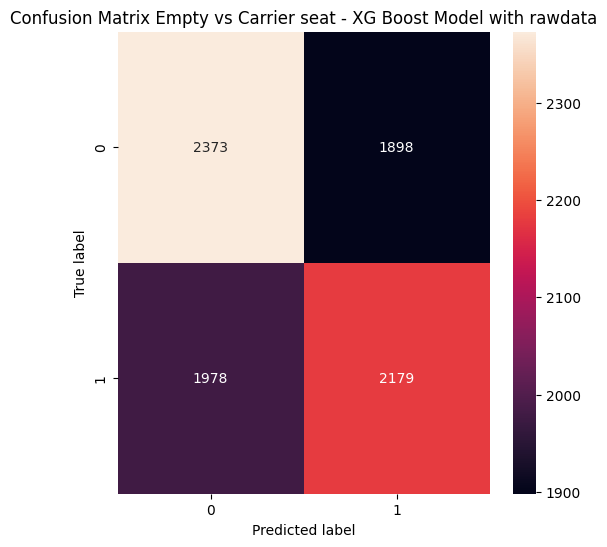

In [82]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix Empty vs Carrier seat - XG Boost Model with rawdata')
plt.show()

# Training with extracted features

In [85]:
# XG Boost Model with extracted features data

In [87]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
# Load your dataset (df_combined)
X = dataset_1_withfeatures.drop(columns=['Object_Presence'])  # Features
y = dataset_1_withfeatures['Object_Presence']  # Labels

# Split into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (XGBoost handles unscaled data well, but scaling can help)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Loss function
    'max_depth': 6,                   # Depth of trees
    'learning_rate': 0.1,              # Step size shrinkage
    'n_estimators': 1000,               # Number of trees
    'random_state': 42
}

# Train XGBoost model
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for extracted features data:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report for extracted features data:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4271
         1.0       1.00      1.00      1.00      4157

    accuracy                           1.00      8428
   macro avg       1.00      1.00      1.00      8428
weighted avg       1.00      1.00      1.00      8428



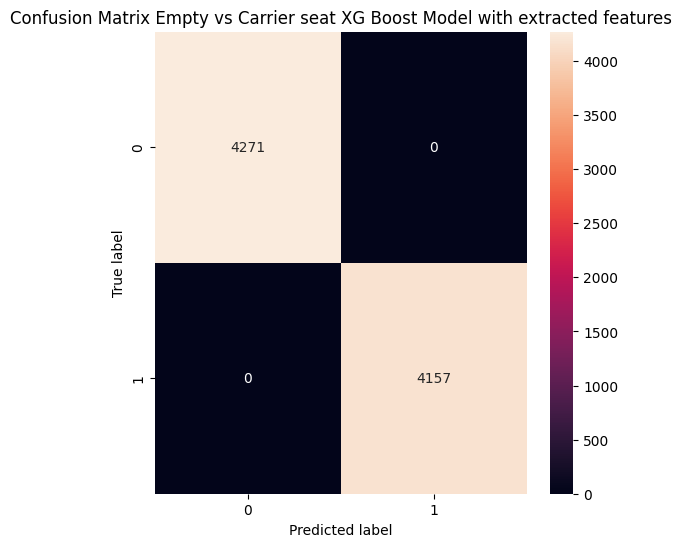

In [90]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix Empty vs Carrier seat XG Boost Model with extracted features')
plt.show()

C:\Users\ANUSHRUTH\AppData\Local\Temp\ipykernel_10368\1275781998.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")


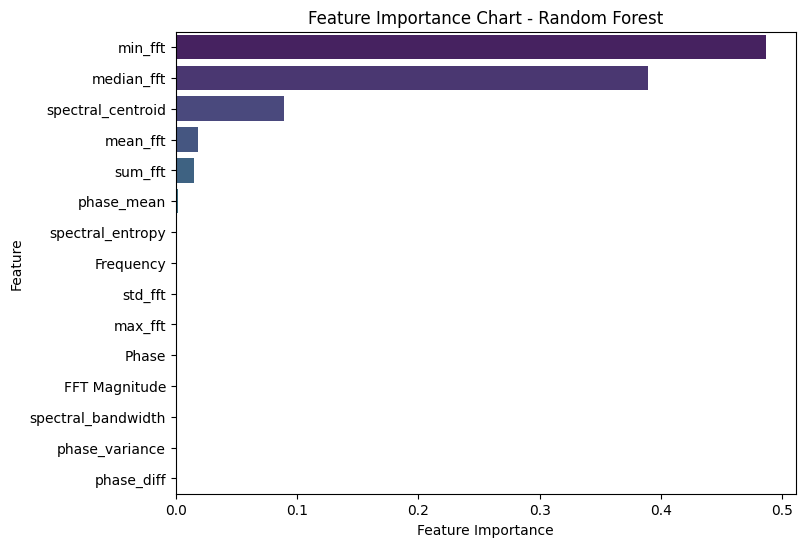

In [93]:
# Feature Importance Plot
importances = clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Chart - Random Forest")
plt.show()


# Feature selection for overcoming OVERFITTING

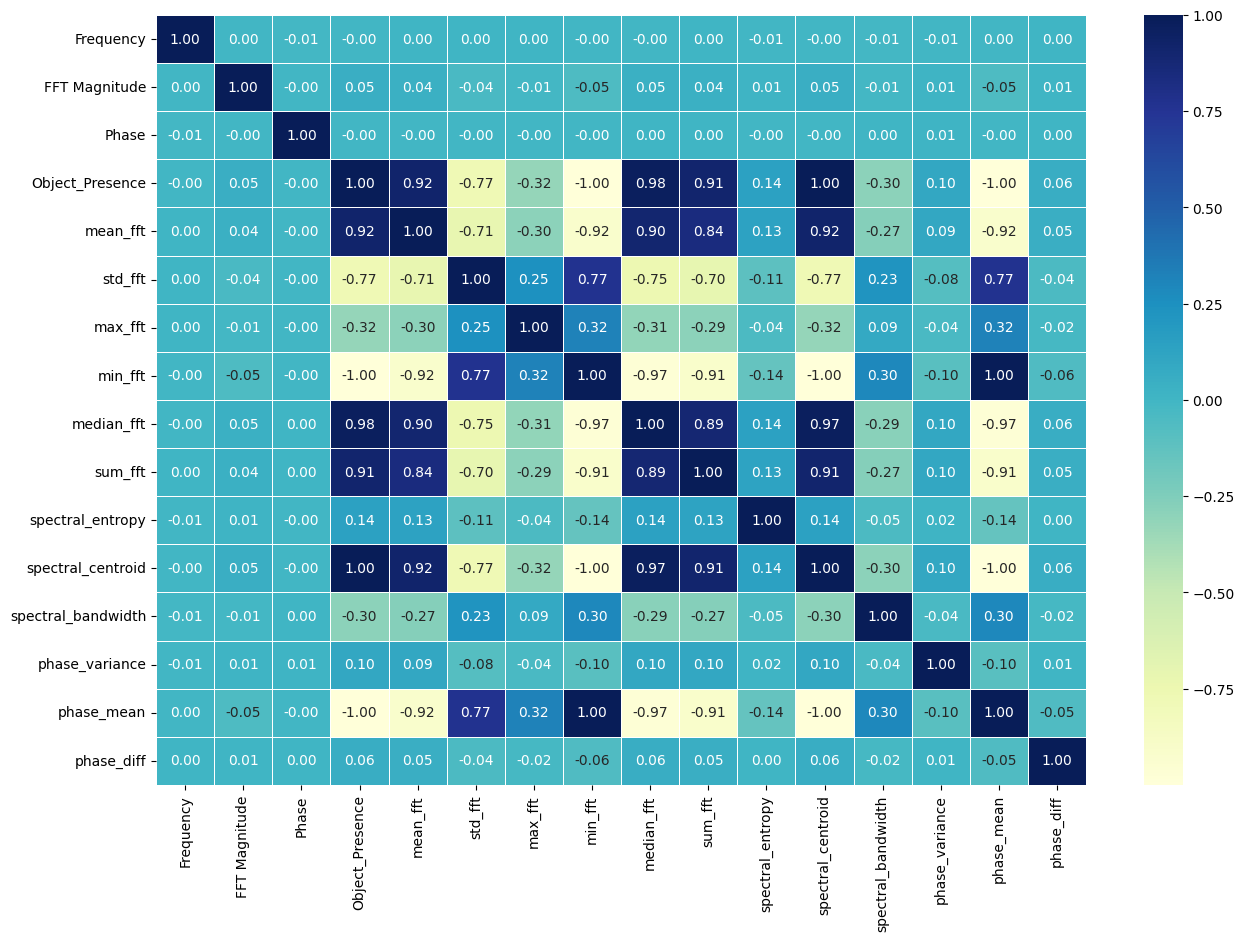

In [96]:
# Plotting correlation matrix for extracted features
corr_matrix = dataset_1_withfeatures.corr()
fig= plt.subplots(figsize=(15, 10))
ax= sns.heatmap(corr_matrix,
               annot=True,
               linewidths=0.5,
               fmt='.2f',
               cmap='YlGnBu')



In [97]:
# Set a threshold for correlation (e.g., 0.8)
threshold = 0.8

# Find pairs of highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > threshold)

# Create a set to store the columns to drop
to_drop = set()

# Loop through the indices of the highly correlated pairs
for i, j in zip(*highly_correlated):
    if i != j:  # Avoid diagonal (self-correlation)
        feature_i = corr_matrix.columns[i]
        feature_j = corr_matrix.columns[j]
        # Ensure we do NOT drop 'Object_Presence'
        if feature_j != "Object_Presence":
            to_drop.add(feature_j)  # Drop one of the correlated features

# Drop the highly correlated features from the dataframe
dataset_1_reduced = dataset_1_withfeatures.drop(columns=to_drop)

# Display the dropped features and new dataframe shape
print("Dropped features: ", to_drop)
print("New dataframe shape: ", dataset_1_reduced.shape)


Dropped features:  {'median_fft', 'sum_fft', 'min_fft', 'mean_fft', 'spectral_centroid', 'phase_mean'}
New dataframe shape:  (42140, 10)


In [100]:
dataset_1_reduced

,Frequency,FFT Magnitude,Phase,Object_Presence,std_fft,max_fft,spectral_entropy,spectral_bandwidth,phase_variance,phase_diff
0,0.000000,88895.479976,0.000000,0.0,1262.756783,90068.823294,9.811311,624495.464728,3.328803,-0.000144
1,92.390019,42749.875976,3.114080,0.0,1238.220060,88624.692488,9.935170,623387.858650,3.338576,-0.000151
2,184.780038,3517.831335,-2.625055,0.0,1251.675179,90704.598360,9.932142,620851.954608,3.192995,-0.000147
3,277.170057,2235.324771,0.837800,0.0,1259.267079,90476.105132,9.789361,614421.739405,3.216829,-0.000146
4,369.560076,1569.457500,-1.524020,0.0,1254.529464,86234.653570,9.586236,617741.754927,3.273637,-0.000143
...,...,...,...,...,...,...,...,...,...,...
42135,-465.029762,1819.265832,-1.426419,1.0,1232.231102,86312.277134,9.492067,611501.024068,3.291966,-0.000149
42136,-372.023810,2781.757042,1.300276,1.0,1192.362551,88175.512858,10.028912,604504.061667,3.231563,-0.000143
42137,-279.017857,3850.745335,-1.609702,1.0,1248.431293,89910.909748,9.691061,604042.816563,3.272468,-0.000144
42138,-186.011905,3807.554627,1.950552,1.0,1228.007001,89353.232911,9.688151,600218.156650,3.264383,-0.000144


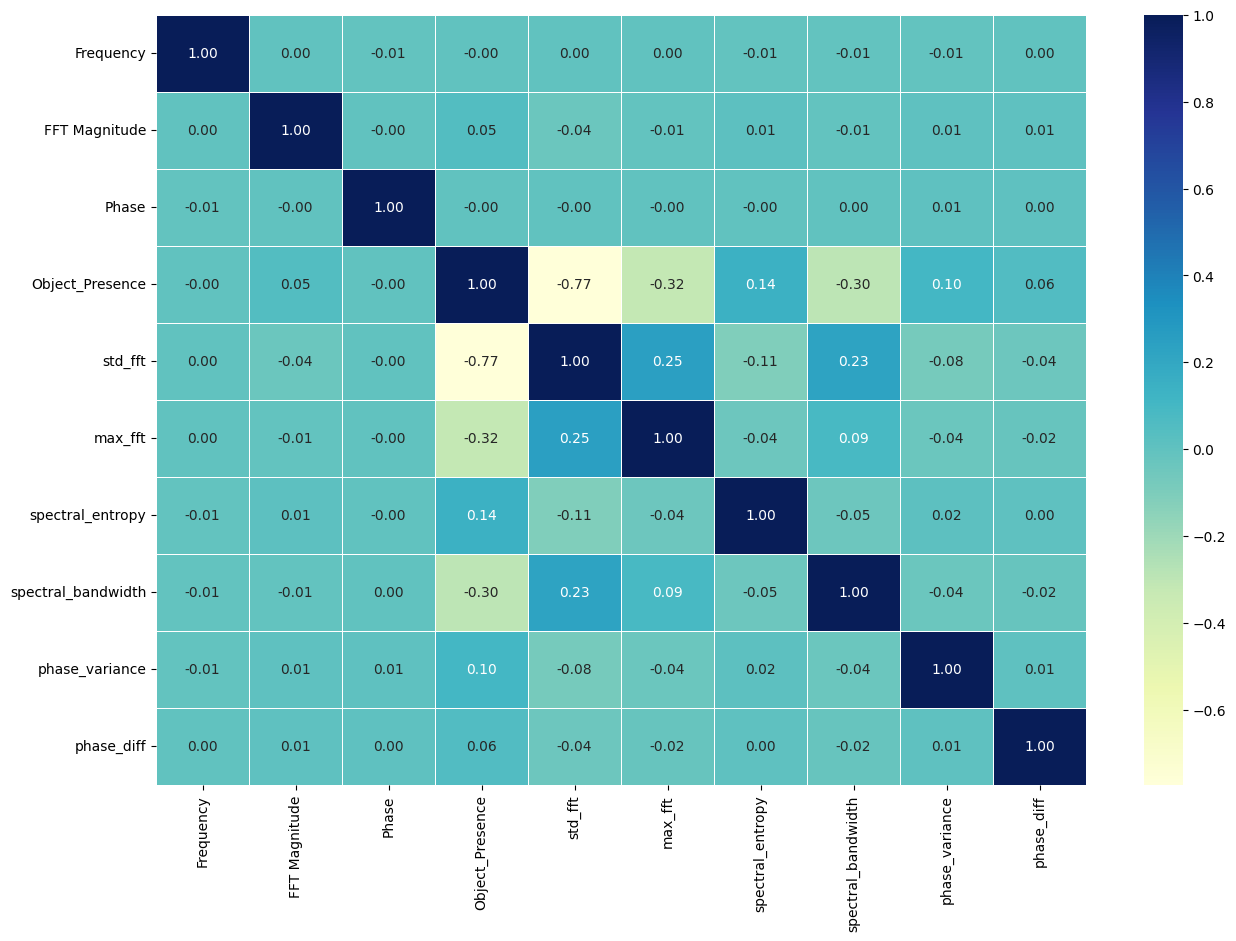

In [102]:
corr_matrix = dataset_1_reduced.corr()
fig= plt.subplots(figsize=(15, 10))
ax= sns.heatmap(corr_matrix,
               annot=True,
               linewidths=0.5,
               fmt='.2f',
               cmap='YlGnBu')


# XG BOOST with selected features using Correlation matrix

In [105]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#dataset_1_reduced = dataset_1_reduced.drop(columns=['std_fft'])

# Load your dataset (df_combined)
X = dataset_1_reduced.drop(columns=['Object_Presence'])  # Features
y = dataset_1_reduced['Object_Presence']  # Labels




# Split into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (XGBoost handles unscaled data well, but scaling can help)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data into DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up XGBoost parameters
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Loss function
    'max_depth': 6,                   # Depth of trees
    'learning_rate': 0.1,              # Step size shrinkage
    'n_estimators': 1000,               # Number of trees
    'random_state': 42
}

# Train XGBoost model
clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report for selected features data:\n", classification_report(y_test, y_pred))



Accuracy: 0.920265780730897

Classification Report for selected features data:
               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      4271
         1.0       0.91      0.93      0.92      4157

    accuracy                           0.92      8428
   macro avg       0.92      0.92      0.92      8428
weighted avg       0.92      0.92      0.92      8428



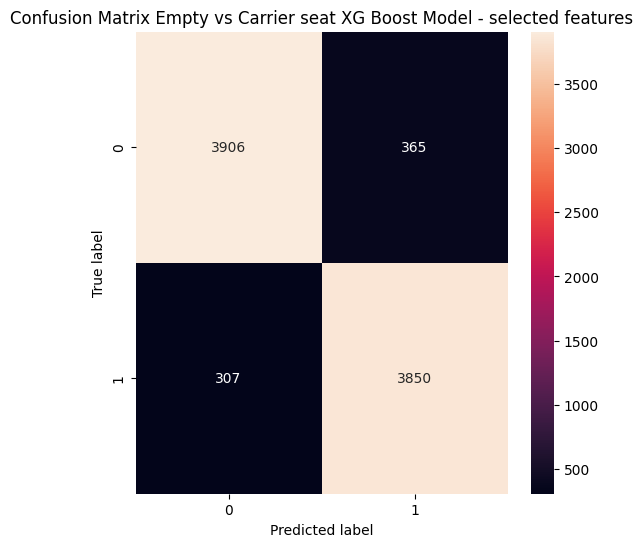

In [107]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix Empty vs Carrier seat XG Boost Model - selected features')
plt.show()

C:\Users\ANUSHRUTH\AppData\Local\Temp\ipykernel_10368\1275781998.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")


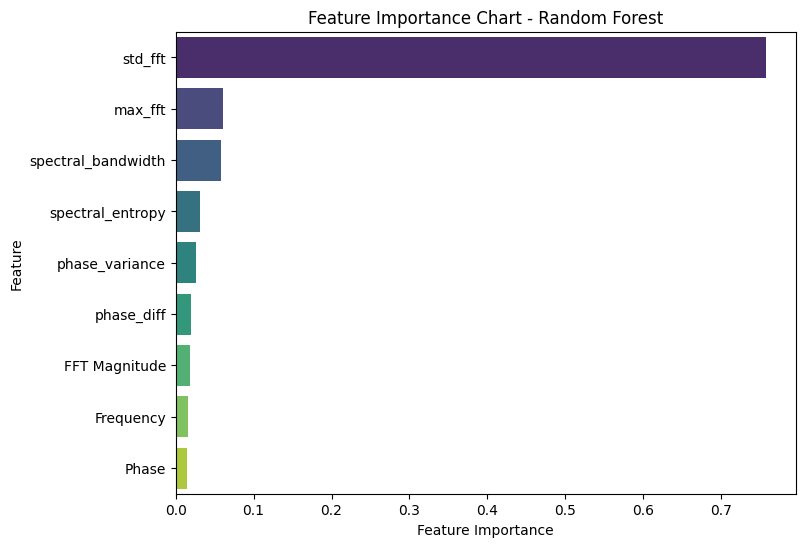

In [109]:
# Feature Importance Plot
importances = clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Chart - Random Forest")
plt.show()


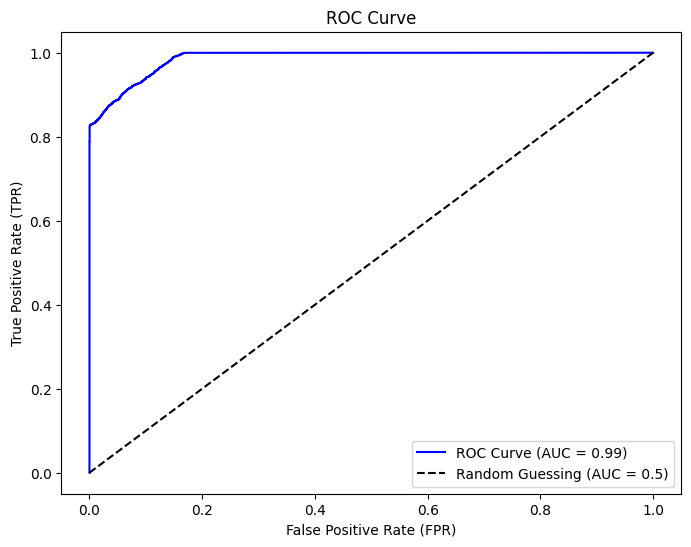

In [111]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of positive class

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_prob)
auc_score
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [113]:
import joblib

# Save the trained XGBoost model
clf.save_model('xgboost_model_Seat_classification.json')

# Save the scaler
joblib.dump(scaler, 'xgboost_scaler_Seat_classification.pkl')



['xgboost_scaler_Seat_classification.pkl']

In [ ]:
import xgboost as xgb

# Load the trained XGBoost model
#clf = xgb.XGBClassifier()
#clf.load_model('xgboost_model_Seat_classification.json')

# Load the scaler
#scaler = joblib.load('scaler_Seat_classification.pkl')

# Example: Transform new data and make predictions
#X_new_scaled = scaler.transform(X_new)
#y_pred = clf.predict(X_new_scaled)


# MLP Model

In [115]:
# MLP model with raw data

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
X = dataset_1_rawdata.drop(columns=['Object_Presence']).values
y = dataset_1_rawdata['Object_Presence'].values

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build MLP model with an explicit Input() layer
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
mlp_loss, mlp_acc = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_acc:.4f}")


Epoch 1/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5398 - loss: 0.6902 - val_accuracy: 0.5431 - val_loss: 0.6879
Epoch 2/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5393 - loss: 0.6901 - val_accuracy: 0.5485 - val_loss: 0.6869
Epoch 3/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5437 - loss: 0.6882 - val_accuracy: 0.5465 - val_loss: 0.6875
Epoch 4/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5470 - loss: 0.6875 - val_accuracy: 0.5447 - val_loss: 0.6882
Epoch 5/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5433 - loss: 0.6878 - val_accuracy: 0.5453 - val_loss: 0.6873
Epoch 6/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5490 - loss: 0.6870 - val_accuracy: 0.5440 - val_loss: 0.6876
Epoch 7/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5456 - loss: 0.6879 - val_accuracy: 0.5501 - val_loss: 0.6869
Epoch 8/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5398 - loss: 0.6879 - 

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
MLP Accuracy: 0.5471

Classification Report for rawdata:
               precision    recall  f1-score   support

         0.0       0.55      0.54      0.55      4271
         1.0       0.54      0.56      0.55      4157

    accuracy                           0.55      8428
   macro avg       0.55      0.55      0.55      8428
weighted avg       0.55      0.55      0.55      8428



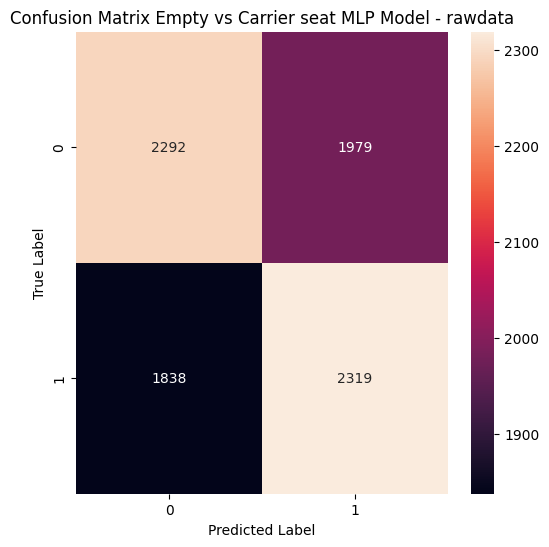

In [118]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions (convert probabilities to binary values: 0 or 1)
y_pred_prob = mlp_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary

# Print accuracy
print(f"MLP Accuracy: {mlp_acc:.4f}")

# Classification report
print("\nClassification Report for rawdata:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Empty vs Carrier seat MLP Model - rawdata")
plt.show()


In [119]:
# MLP model with extracted features

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
X = dataset_1_withfeatures.drop(columns=['Object_Presence']).values
y = dataset_1_withfeatures['Object_Presence'].values

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build MLP model with an explicit Input() layer
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
mlp_loss, mlp_acc = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_acc:.4f}")


Epoch 1/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9818 - loss: 0.0699 - val_accuracy: 1.0000 - val_loss: 7.1913e-05
Epoch 2/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9998 - loss: 6.4499e-04 - val_accuracy: 1.0000 - val_loss: 1.5025e-05
Epoch 3/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 1.2125e-05 - val_accuracy: 1.0000 - val_loss: 6.9597e-06
Epoch 4/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 5.6937e-06 - val_accuracy: 1.0000 - val_loss: 3.4873e-06
Epoch 5/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 2.9264e-06 - val_accuracy: 1.0000 - val_loss: 1.8362e-06
Epoch 6/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 1.5455e-06 - val_accuracy: 1.0000 - val_loss: 9.9302e-07
Epoch 7/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 8.6382e-07 - val_accuracy: 1.0000 - val_loss: 5.4682e-07
Epoch 8/10
1054/1054 ━━━━━━━━━━━━━━━━━

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
MLP Accuracy: 1.0000

Classification Report for extracted features data:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4271
         1.0       1.00      1.00      1.00      4157

    accuracy                           1.00      8428
   macro avg       1.00      1.00      1.00      8428
weighted avg       1.00      1.00      1.00      8428



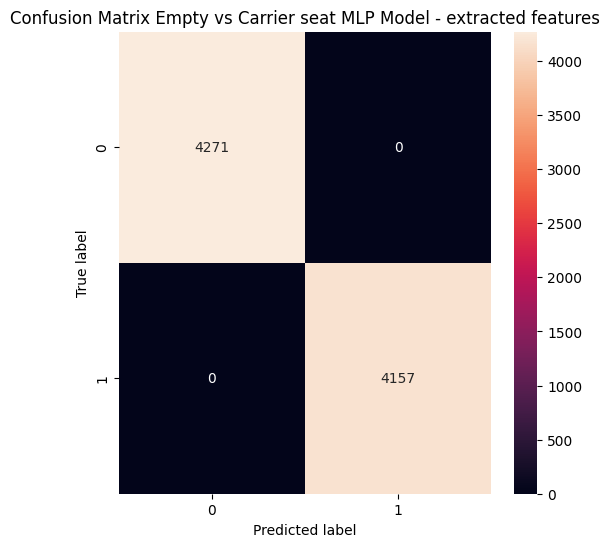

In [121]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions (convert probabilities to binary values: 0 or 1)
y_pred_prob = mlp_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary

# Print accuracy
print(f"MLP Accuracy: {mlp_acc:.4f}")

# Classification report
print("\nClassification Report for extracted features data:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Empty vs Carrier seat MLP Model - extracted features")
plt.show()


In [122]:
# MLP model with selected features using correlation matrix for overcoming overfitting

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
X = dataset_1_reduced.drop(columns=['Object_Presence']).values
y = dataset_1_reduced['Object_Presence'].values

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build MLP model with an explicit Input() layer
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
mlp_loss, mlp_acc = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_acc:.4f}")


Epoch 1/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8667 - loss: 0.3018 - val_accuracy: 0.8906 - val_loss: 0.2193
Epoch 2/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8914 - loss: 0.2187 - val_accuracy: 0.8917 - val_loss: 0.2145
Epoch 3/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8938 - loss: 0.2106 - val_accuracy: 0.8972 - val_loss: 0.2069
Epoch 4/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9017 - loss: 0.1988 - val_accuracy: 0.9025 - val_loss: 0.1937
Epoch 5/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9056 - loss: 0.1874 - val_accuracy: 0.9089 - val_loss: 0.1788
Epoch 6/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9113 - loss: 0.1725 - val_accuracy: 0.9070 - val_loss: 0.1739
Epoch 7/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9134 - loss: 0.1626 - val_accuracy: 0.9103 - val_loss: 0.1645
Epoch 8/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9163 - loss: 0.1593 - 

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
MLP Accuracy: 0.9093

Classification Report for selected features data:
               precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      4271
         1.0       0.87      0.95      0.91      4157

    accuracy                           0.91      8428
   macro avg       0.91      0.91      0.91      8428
weighted avg       0.91      0.91      0.91      8428



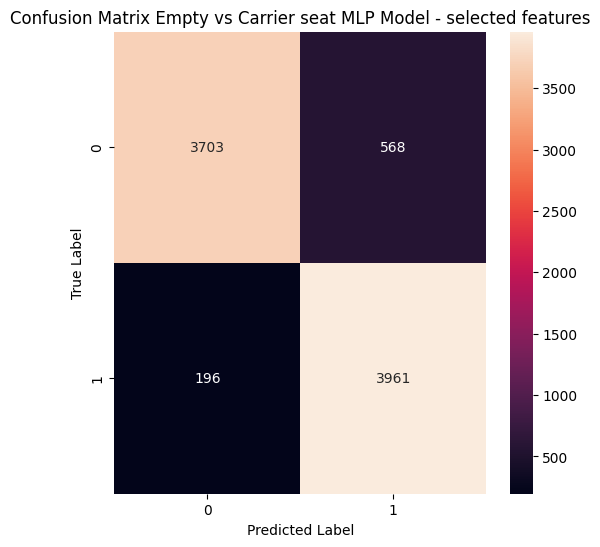

In [124]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions (convert probabilities to binary values: 0 or 1)
y_pred_prob = mlp_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to binary

# Print accuracy
print(f"MLP Accuracy: {mlp_acc:.4f}")

# Classification report
print("\nClassification Report for selected features data:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Empty vs Carrier seat MLP Model - selected features")
plt.show()


In [125]:
import joblib
from tensorflow.keras.models import load_model

# Save the trained model
mlp_model.save('mlp_model_Seat_Classification.h5')

# Save the scaler
joblib.dump(scaler, 'mlp_scaler_Seat_Classification.pkl')


['mlp_scaler_Seat_Classification.pkl']

In [ ]:
# Load the trained model
#mlp_model = load_model('mlp_model_Seat_Classification.h5')

# Load the scaler
#scaler = joblib.load('scaler_Seat_Classification.pkl')

# Example: Transform new data and make predictions
#X_new_scaled = scaler.transform(X_new)
#y_pred = mlp_model.predict(X_new_scaled)
